In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import math
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
#Check GPU acceleration availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda')

True
1
0
NVIDIA GeForce RTX 2060


In [3]:
#Check GPU acceleration availability for TensorFlow
#tf.test.is_gpu_available()

In [4]:
   # Read the dataset
dataset = pd.read_csv('train_valid_median_160columns.csv')

# Split the data into features (X) and target variable (y)
features = dataset.iloc[:, 9:]
target = dataset.iloc[:, 8]

# Split the dataset into a training set and a test set.
# 80% of the data will be used for training and 20% for testing.
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Check the first few rows 
print(x_train.head(6))
print(x_test.head(6))
x_train.to_csv('my_dataset.csv', index=False)
y_train.to_csv('my_dataset1.csv', index=False)

      stay_len  prev_admits       age  gender  ethnicity  Y90-Y99  G30-G32  \
4401 -0.656202    -0.406394  0.785597       1          6        0        0   
3508 -0.311923     1.004126 -0.137411       1          2        0        0   
4250 -0.254543     1.004126 -0.137411       0          2        0        0   
2030  0.089736    -0.406394  1.400935       0          5        0        0   
9370 -0.598822    -0.406394 -2.291095       1          6        0        0   
7412 -0.311923    -0.406394  1.462469       0          6        0        0   

      O85-O92  C60-C63  F40-F48  ...  PRE-NATAL VITAMINS  ANESTHETICS  \
4401        0        0        0  ...           -0.015166     0.215206   
3508        0        0        0  ...           -0.015166    -0.464590   
4250        0        0        0  ...           -0.015166     0.215206   
2030        0        0        0  ...           -0.015166    -0.464590   
9370        0        0        0  ...           -0.015166     0.215206   
7412        0  

In [5]:
#Check missing values
print(x_train.isnull().sum())
print(y_train.isnull().sum())

# Percentage of missing values in each column
print(x_train.isnull().mean()*100)
print(y_train.isnull().mean()*100)

# Drop the rows where at least one element is missing.
#x_train = x_train.dropna()
#y_train = y_train.dropna()

#fill the missing values with mean
#x_train = x_train.fillna(x_train.mean())
#y_train = y_train.fillna(y_train.mean())

stay_len              0
prev_admits           0
age                   0
gender                0
ethnicity             0
                     ..
SEDATIVE/HYPNOTICS    0
ANTIDOTES             0
AUTONOMIC DRUGS       0
VITAMINS              0
BIOLOGICALS           0
Length: 158, dtype: int64
0
stay_len              0.0
prev_admits           0.0
age                   0.0
gender                0.0
ethnicity             0.0
                     ... 
SEDATIVE/HYPNOTICS    0.0
ANTIDOTES             0.0
AUTONOMIC DRUGS       0.0
VITAMINS              0.0
BIOLOGICALS           0.0
Length: 158, dtype: float64
0.0


In [7]:
# Convert dataframe to tensor
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDataset
train_data = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Define DataLoader with appropriate batch size
batch_size = 64  # Adjust this depending on your VRAM availability
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# Define DataLoader with appropriate batch size
test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

In [15]:
# Define model architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(158, 64)  # 158 input features
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)  # 1 output

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Define the model
model = NeuralNet()

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # or another appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 20  # adjust as needed
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        # Move features and labels to the GPU
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss.item()}')

print('Finished Training')

C:\Users\86139\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Step 100/145, Loss: 0.13330700993537903


C:\Users\86139\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/20, Step 100/145, Loss: 0.15348422527313232
Epoch 3/20, Step 100/145, Loss: 0.15332193672657013
Epoch 4/20, Step 100/145, Loss: 0.132428839802742
Epoch 5/20, Step 100/145, Loss: 0.1526990830898285
Epoch 6/20, Step 100/145, Loss: 0.15284842252731323
Epoch 7/20, Step 100/145, Loss: 0.1737791895866394
Epoch 8/20, Step 100/145, Loss: 0.17228135466575623
Epoch 9/20, Step 100/145, Loss: 0.21281901001930237
Epoch 10/20, Step 100/145, Loss: 0.13222604990005493
Epoch 11/20, Step 100/145, Loss: 0.1526787132024765
Epoch 12/20, Step 100/145, Loss: 0.17246344685554504
Epoch 13/20, Step 100/145, Loss: 0.19439220428466797
Epoch 14/20, Step 100/145, Loss: 0.1925455927848816
Epoch 15/20, Step 100/145, Loss: 0.18225997686386108
Epoch 16/20, Step 100/145, Loss: 0.15249784290790558
Epoch 17/20, Step 100/145, Loss: 0.16305795311927795
Epoch 18/20, Step 100/145, Loss: 0.15309910476207733
Epoch 19/20, Step 100/145, Loss: 0.132485032081604
Epoch 20/20, Step 100/145, Loss: 0.14245155453681946
Finished 

AUC Score: 0.4744720090890698


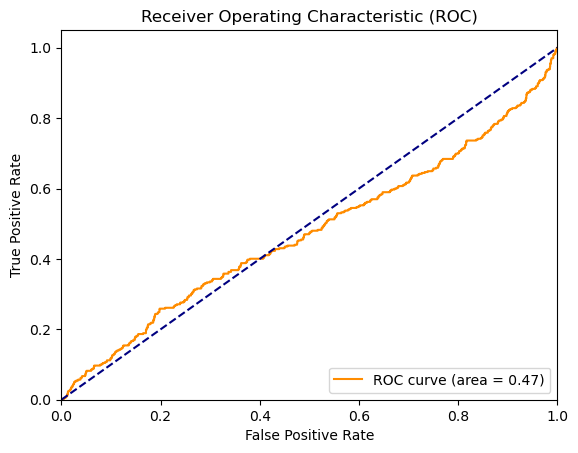

In [16]:
model.eval()  # set the model to evaluation mode

# initialize a list to hold all the probabilities and real values
probs_list = []
real_values_list = []

with torch.no_grad():  # disable gradient calculation
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        outputs = torch.sigmoid(model(features))  # assuming your model returns logits
        probs_list.extend(outputs.detach().cpu().numpy().tolist())
        real_values_list.extend(labels.cpu().numpy().tolist())

auc_score = roc_auc_score(real_values_list, probs_list)
print(f'AUC Score: {auc_score}')

fpr, tpr, _ = roc_curve(real_values_list, probs_list)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##### Epoch = 80, LR = 0.001, Batch Size = 64, AUC Score: 0.5667031111387796
##### Epoch = 40, LR = 0.001, Batch Size = 64, AUC Score: 0.5738577705839935
##### Epoch = 30, LR = 0.001, Batch Size = 64, AUC Score: 0.5873072074455667
##### Epoch = 20, LR = 0.001, Batch Size = 64, AUC Score: 0.4744720090890698